In [1]:
import matplotlib.pyplot as plt
import heapq

In [2]:
class Node(object):

    def __init__(self, value):
        self.value = value

    def __eq__(self, other):
        if isinstance(other, Node):
            return self.value == other.value
        elif isinstance(other, str):
            return self.value == other
        raise ValueError('Unable to convert from {} to {}',format(type(other), str(type(self))))

    def __hash__(self):
        return hash(self.value)

    def __str__(self):
        return self.value

    def __repr__(self):
        return self.__str__()

    def __lt__(self, other):
        return self.value < other.value

In [3]:
class Graph(object):

    def __init__(self, directed=False):
        self.adjacency_list = {}
        self.directed = directed

    def add(self, node1, node2, weight=1, accessibility_weight=1):
        # If one of the nodes is not in the adjacency list, add it
        if node1 not in self.adjacency_list:
            self.adjacency_list[node1] = []
        if node2 not in self.adjacency_list:
            self.adjacency_list[node2] = []

        self.adjacency_list[node1].append((node2, weight, accessibility_weight))
        if not self.directed:
            self.adjacency_list[node2].append((node1, weight, accessibility_weight))

    def add_node(self, node):
        if node not in self.adjacency_list:
            self.adjacency_list[node] = []

    def add_edge(self, node1, node2, weight=1, accessibility_weight=1):
        if node1 not in self.adjacency_list:
            self.add_node(node1)
        if node2 not in self.adjacency_list:
            self.add_node(node2)

        self.adjacency_list[node1].append((node2, weight, accessibility_weight))
        if not self.directed:
            self.adjacency_list[node2].append((node1, weight, accessibility_weight))

    def get_nodes(self):
        return list(self.adjacency_list.keys())

    def load(self, path):
        with open(path, 'r') as file:
            for line in file:
                node1, node2, weight, accessibility_weight = line.split()  # Each line has node1, node2, weight, and accessibility_weight separated by tab
                self.add(node1, node2, int(weight), int(accessibility_weight))

    @classmethod
    def static_load(cls, path):
        graph = Graph()
        graph.load(path)
        return graph

    def save(self, path):
        with open(path, 'w') as file:
            for node, neighbors in self.adjacency_list.items():
                for neighbor, weight, accessibility_weight in neighbors:
                    file.write(
                        str(node) + " " + str(neighbor) + " " + str(weight) + " " + str(accessibility_weight) + "\n")

    def shortest_path(self, start, end, accessibility_level):
        return self._astar_shortest_path(start, end, accessibility_level)

    def _astar_shortest_path(self, start, end, accessibility_level):
        priority_queue = [(0, start)]  # (f, node)
        distances = {node: float('inf') for node in self.adjacency_list}
        distances[start] = 0
        parents = {}

        while priority_queue:
            _, current_node = heapq.heappop(priority_queue)

            if current_node == end:
                return distances[end], self._reconstruct_path(parents, start, end)

            for neighbor, weight, accessibility_weight in self.adjacency_list[current_node]:
                if accessibility_weight <= accessibility_level:
                    tentative_distance = distances[current_node] + weight
                    if tentative_distance < distances[neighbor]:
                        distances[neighbor] = tentative_distance
                        parents[neighbor] = current_node
                        heuristic = self._heuristic(neighbor, end)
                        f_score = tentative_distance + heuristic
                        heapq.heappush(priority_queue, (f_score, neighbor))

        return float('inf'), []  # No path found

    def _heuristic(self, node, goal):
        return 0

    def _reconstruct_path(self, parents, start, end):
        path = [end]
        while path[-1] != start:
            path.append(parents[path[-1]])
        path.reverse()
        return path

In [4]:
class Room(Node):
    def __init__(self, value, x=0, y=0):
        super(Room, self).__init__(value)
        self.value = value
        self.x = x
        self.y = y

In [5]:
class RoomMapper(Graph):
    def __init__(self):
        super(RoomMapper, self).__init__()
        self.rooms = {}

    def add_room(self, name, x, y):
        room = Room(name, x, y)
        self.rooms[name] = room
        self.add_node(room)
        return room

    def add_connection(self, room1_name, room2_name, distance=1, accessibility=0):
        room1 = self.rooms[room1_name]
        room2 = self.rooms[room2_name]
        self.add_edge(room1, room2, distance, accessibility)

    def get_room(self, name):
        return self.rooms.get(name)

    def find_path(self, start_name, end_name, max_accessibility=float('inf')):
        start_room = self.rooms[start_name]
        end_room = self.rooms[end_name]
        distance, path = self.shortest_path(start_room, end_room, max_accessibility)
        return distance, path

    def save(self, filename):
        with open(filename, 'w') as f:
            # Write rooms (coordinates)
            for room in self.rooms.itervalues():
                f.write("{0} {1} {2}\n".format(room.value, room.x, room.y))

            # Write empty line as delimiter
            f.write("\n")

            # Write connections
            for node, neighbors in self.adjacency_list.iteritems():
                for neighbor, weight, accessibility in neighbors:
                    if self.directed or node.value < neighbor.value:  # Avoid duplicate edges in undirected graph
                        f.write("{0} {1} {2} {3}\n".format(
                            node.value, neighbor.value, weight, accessibility))

    def load(self, filename):
        self.rooms.clear()
        self.adjacency_list.clear()

        with open(filename, 'r') as f:
            # Read all lines and split by empty line
            content = f.read().strip()
            coords_section, graph_section = content.split('\n\n')

            # Process coordinates
            for line in coords_section.split('\n'):
                if line.strip():
                    name, x, y = line.strip().split()
                    self.add_room(name, float(x), float(y))

            # Process graph connections
            for line in graph_section.split('\n'):
                if line.strip():
                    room1, room2, distance, accessibility = line.strip().split()
                    self.add_connection(room1, room2, float(distance), int(accessibility))

    @classmethod
    def from_file(cls, filename):
        mapper = cls()
        mapper.load(filename)
        return mapper

    def draw(self):
        plt.figure(figsize=(8, 6))

        # Draw edges
        for node, neighbors in self.adjacency_list.items():
            for neighbor, weight, accessibility_weight in neighbors:
                plt.plot([self.rooms[node].x, self.rooms[neighbor].x],
                         [self.rooms[node].y, self.rooms[neighbor].y], 'k-')
                plt.text((self.rooms[node].x + self.rooms[neighbor].x) / 2,
                         (self.rooms[node].y + self.rooms[neighbor].y) / 2,
                         str(weight) + ", " + str(accessibility_weight), fontsize=10, color='b')

        # Draw nodes
        for room_id, room in self.rooms.items():
            plt.plot(room.x, room.y, 'ro')
            plt.text(room.x, room.y, str(room_id), fontsize=12)

        plt.title('Graph Visualization')
        plt.xlabel('Node')
        plt.ylabel('Weight')
        plt.grid(True)
        plt.show()

In [12]:
mapper = RoomMapper()

mapper.add_room("Lobby", 0, 0)
mapper.add_room("Cafe", 1, 1)
mapper.add_room("Library", -1, 1)
mapper.add_room("Office", 0, 2)

mapper.add_connection("Lobby", "Cafe", 3, 1)  # Stairs
mapper.add_connection("Lobby", "Library", 3, 0)  # Accessible
mapper.add_connection("Cafe", "Library", 1, 0)
mapper.add_connection("Cafe", "Office", 2, 0)
mapper.add_connection("Library", "Office", 4, 0)

Accessible path from Lobby to Office: Lobby -> Library -> Cafe -> Office
Distance: 6


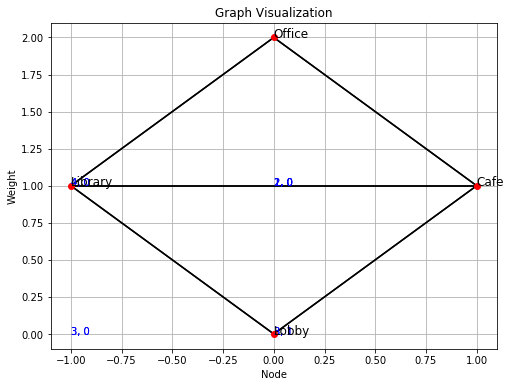

In [13]:
distance, path = mapper.find_path("Lobby", "Office", max_accessibility=0)
print "Accessible path from Lobby to Office: {0}".format(" -> ".join(str(room) for room in path))
print "Distance: {0}".format(distance)

# Visualize the map
mapper.draw()

Accessible path from Lobby to Office: Lobby -> Cafe -> Office
Distance: 5


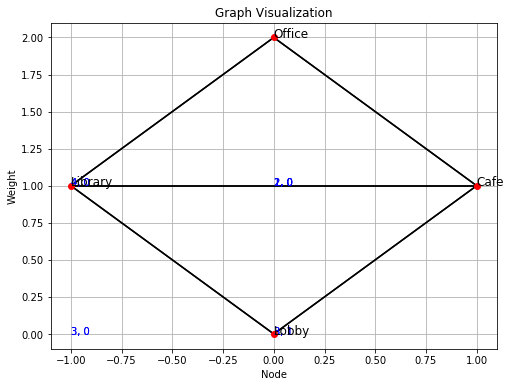

In [11]:
distance, path = mapper.find_path("Lobby", "Office", max_accessibility=1)
print "Accessible path from Lobby to Office: {0}".format(" -> ".join(str(room) for room in path))
print "Distance: {0}".format(distance)

# Visualize the map
mapper.draw()